## Physics Informed Neural Networks to find Eigenfunctions and values of PDEs

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import time
import copy
torch.autograd.set_detect_anomaly(True)
#torch.set_num_threads(8)
#torch.set_num_interop_threads(8)

intra_op_t = torch.get_num_interop_threads()
inter_op_t = torch.get_num_threads()
torch.manual_seed(128)
type_ = torch.float32

print(f"Intra op threds: {intra_op_t}\nInter op threds: {inter_op_t}")

Intra op threds: 8
Inter op threds: 8


In [22]:
class Sin(nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)

class NeuralNet(nn.Module):

    def __init__(self, n_hidden_layers, neurons, retrain_seed):
        super(NeuralNet, self).__init__()
        self.neurons = neurons
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = Sin()
        
        # determine symmetry
        self.sym = 1
        
        # min lambda
        self.min_lambda = 0

        self.layer_I = nn.Linear(1,1)
        self.input_layer = nn.Linear(2, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, 1)
        self.retrain_seed = retrain_seed
        self.init_xavier()

    def forward(self, x):
        x = x.reshape(-1,1)
        lambda_ = self.layer_I(torch.ones_like(x)).reshape(-1,1)
        lambda_ = torch.abs(lambda_) #+ self.min_lambda

        x_plus = x
        x_plus = torch.cat((x_plus, lambda_), dim=1)
        x_plus = self.activation(self.input_layer(x_plus))
        for _, l in enumerate(self.hidden_layers):
            #x_plus = torch.cat((x_plus, lambda_), dim=1)
            x_plus = self.activation(l(x_plus))

        x_minus = -x
        x_minus = torch.cat((x_minus, lambda_), dim=1)
        x_minus = self.activation(self.input_layer(x_minus))
        for _, l in enumerate(self.hidden_layers):
            #x_minus = torch.cat((x_minus, lambda_), dim=1)
            x_minus = self.activation(l(x_minus))
        
        hub_layer = x_plus + self.sym * x_minus
        #hub_layer = torch.cat((x_plus + self.sym * x_minus, lambda_), dim=1)
        return self.output_layer(hub_layer), lambda_

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0)

        self.apply(init_weights)

In [23]:
# Define some more general functions
def dfx(x,f):
    # Calculate the derivative with auto-differention
    gopts = torch.ones(x.shape, dtype=dtype)
    return grad([f], [x], grad_outputs=gopts, create_graph=True)[0]

def perturbPoints(grid,t0,tf,sig=0.5):
    # stochastic perturbation of the evaluation points
    # force t[0]=t0  & force points to be in the t-interval
    delta_t = grid[1] - grid[0]  
    noise = delta_t * torch.randn_like(grid)*sig
    t = grid + noise
    t.data[2] = torch.ones(1,1)*(-1)
    t.data[t<t0]=t0 - t.data[t<t0]
    t.data[t>tf]=2*tf - t.data[t>tf]
    t.data[0] = torch.ones(1,1)*t0

    t.data[-1] = torch.ones(1,1)*tf
    t.requires_grad = False
    return t

In [24]:
def parametricSolutions(t, nn, t0, x1):
    N1,N2 = nn(t)
    dt =t-t0
    f = (1-torch.exp(-dt))*(1-torch.exp(dt-12))
    psi_hat  = x1  + f*N1
    return psi_hat


def hamEqs_Loss(t,psi, E,V):

    psi_dx = dfx(t,psi)
    psi_ddx= dfx(t,psi_dx)
    f = psi_ddx/2 + (E-V)*psi
    L  = (f.pow(2)).mean(); 
    H_psi = -1*psi_ddx/2 + (V)*psi
    return L, f, H_psi

In [25]:
def potential(Xs):
  # Gives the potential at each point
  # Takes in tensor of x points, gives back tensor of V at each point
  L = 1

  Xsnp = Xs.data.numpy()
  Vnp = (np.heaviside(-1*Xsnp-1.7, 0) + np.heaviside(Xsnp-1.7, 0))*20

  Vtorch = torch.from_numpy(Vnp)
  return Vtorch



In [26]:
def assemble_points(n_points: int, L : float) -> torch.Tensor:
    sobol = torch.quasirandom.SobolEngine(dimension=1)
    input_int = 2 * L * (sobol.draw(n_points)) - L
    return input_int.reshape(-1,1).type(type_)

def compute_pde_residual(input: torch.Tensor, nn : NeuralNet, L : float) -> tuple[torch.Tensor]:
    """Compute residual

    Args:
        input (torch.Tensor): input points
        nn (NeuralNet): net representing the non-parametrized solution
        L (float): Interval lenght

    Returns:
        tuple[torch.Tensor]: (residual values, function values, lambda)
    """
    N, lam = nn(input)
    f = para_f(input, N, L)
    f = f.reshape(-1,1)
    lam = torch.abs(lam)
    lam = lam.reshape(-1,1)
    
    pot = potential(input)
    
    grad_x = torch.autograd.grad(f.sum(), input, create_graph=True)[0].reshape(-1,1)
    grad_xx = torch.autograd.grad(grad_x.sum(), input, create_graph=True)[0].reshape(-1,1)

    pde_residual = grad_xx / 2 + (lam - pot) * f
    return pde_residual.reshape(-1, 1), f, lam
        
# function computing the solution from x and the neural net output
def para_f(x : torch.Tensor, N : torch.Tensor, L : float) -> torch.Tensor:
    """computes parametized solution form input points x and nonparametrized values N

    Args:
        x (torch.Tensor): input points
        N (torch.Tensor): nonparametrized solution 
        L (float): endpoint

    Returns:
        torch.Tensor: parametrized solution
    """
    assert(x.shape == N.shape)
    def g(x : torch.Tensor) -> torch.Tensor:
        return (1 - torch.exp(- x - L)) * (1 - torch.exp(-(x - L)))
        
    return N * g(x)
    
def potential(x : torch.Tensor):
    V0 = 20
    l = np.pi / 2
    x = x.data.numpy()
    pot = (np.heaviside(-x - l, 0) + np.heaviside(x - l, 0))*V0
    pot = torch.from_numpy(pot)
    return pot


################################################################################################
def fit(num_epochs : int, 
        layers : int,
        neurons : int, 
        lr : float, 
        n_points : int, 
        L : float, 
        inv_verbosity : int,
        solutions = list(),
        last_lambda = 0):

    # log
    loss_history = list()
    pde_loss_history = list()
    orth_loss_history = list()
    norm_loss_history = list()
    labmda_history = list()
    pde_losses = list()
    orth_cnt = 0
    best_loss = 1e10
    orth_epoch = 0
    
    # neural net
    nn = NeuralNet(n_hidden_layers=layers, neurons=neurons, retrain_seed=0)
    nn.init_xavier()
    nn.min_lambda = last_lambda
    
    # optimizer
    betas = [0.999, 0.9999]
    optimizer = optim.Adam(nn.parameters(), lr=lr, betas=betas)

    # data
    input = assemble_points(n_points, L)
    input.requires_grad = True

    # train
    time0 = time.time()

    # Loop over epochs
    for epoch in range(num_epochs):
        orth_epoch += 1

        optimizer.zero_grad()
        
        # init loss
        loss = 0.0

        # assemble points
        input = torch.linspace(-L,L, n_points)
        noise = L * torch.randn_like(input) / n_points
        input = input + noise
        input = input.reshape(-1,1)
        input.requires_grad = True
        
        # PDE loss
        r_pde, f, lam = compute_pde_residual(input=input, nn=nn, L=L)
        lam = lam[0].item()
            
        l_pde = r_pde.pow(2).mean()
        pde_losses.append(l_pde.detach().item())
        loss = l_pde
            
        # Normalization Loss
        N, _ = nn.forward(input)
        f = para_f(input, N, L)
        lnorm = (torch.dot(f.flatten(),f.flatten()).sqrt() - n_points / (2 * L)).pow(2)
        loss = loss + lnorm
            
        # Orthogonal loss and lambda loss
        n_solutions = len(solutions)
        psi_eigen = torch.zeros_like(input).type(type_)
        ll = torch.tensor([0]).type(type_)
        for i in range(n_solutions):
            nn_orth = solutions[i]
            N_orth, _ = nn_orth.forward(input)
            f_orth = para_f(input, N_orth, L)
            psi_eigen = psi_eigen + f_orth
            
        lorth =  0.02 * torch.dot(psi_eigen.flatten(),f.flatten()).pow(2).sqrt()
        if n_solutions > 0:
            loss = loss + lorth
            
        # update network
        loss.backward(retain_graph=False)
        optimizer.step()
        
        # write histories
        loss_history.append(loss.item())
        pde_loss_history.append(l_pde.item())
        orth_loss_history.append(lorth.item())
        norm_loss_history.append(lnorm.item())
        labmda_history.append(lam)

        # Compute stopping criterion
        window = 1000
        mov_avg = 0
        if len(pde_losses) >= window + 1:
            mov_avg = np.mean(np.array(pde_losses)[-window:] - np.array(pde_losses)[-window-1:-1])
        else:
            mov_avg = np.mean(np.array(pde_losses)[1:] - np.array(pde_losses)[:-1])
                
        # update current best solution if possible
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_lambda = lam
            nn_cp = copy.deepcopy(nn)
            best_sol = nn_cp
            
        # stop and append solution if model has converged
        thresh = np.exp(-14.5)
        if orth_epoch == 1.5e4 or (mov_avg < thresh and mov_avg > 0):
            solutions.append(best_sol)
            nn.init_xavier()
            nn.min_lambda = best_lambda
            pde_losses = []
            orth_cnt = orth_cnt + 1
            best_loss = 2e10
            orth_epoch = 0
            if l_pde >= 1.5e1:
                nn.sym = -nn.sym

        # print losses of the current epoch
        if epoch % inv_verbosity == 0: 
            print(f"epoch {epoch}: orth sol {orth_cnt}| Total loss: ", format(loss.item(),'.5f'), 
                    "| mavg: ", format(mov_avg,'.7f'), 
                    "| lam: ", format(lam,'.6f'), 
                    "| lpde: ", format(l_pde.item(),'.4f'), 
                    "| lnorm: ", format(lnorm.item(),'.4f'), 
                    "| lorth: ", format(lorth.item(),'.4f'))
            print(f"Best loss {best_loss}")


    time1 = time.time()
    print('Final Loss: ', loss_history[-1], ' in ', time0 - time1, " seconds" )

    return loss_history, pde_loss_history, orth_loss_history,\
        norm_loss_history, labmda_history, solutions, neurons, layers



In [27]:
def resotre_solutions(path : str):
    solutions = list()
    dic = torch.load(path)
    layers = dic["layer"]
    neurons = dic["neurons"]
    last_lambda = 0
    for state in dic["solutions"]:
        nn = NeuralNet(layers,neurons,0)
        nn.load_state_dict(state)
        nn.min_lambda = last_lambda
        _, lam = nn.forward(torch.zeros((1,1)))
        last_lambda = lam.item()
        solutions.append(nn)
    return solutions, last_lambda

In [28]:
#solutions, last_lambda = resotre_solutions("last_training_.pt")[:3]
loss_hist, pde_loss_hist, orth_loss_hist, norm_loss_hist,\
    lambda_hist, solutions, neurons, layer = fit(num_epochs=60000, 
           layers=2, 
           neurons=50, 
           lr=8e-3, 
           n_points=1000,
           L = 1,
           inv_verbosity=100,
           #solutions = solutions,
           #last_lambda=last_lambda
            )


epoch 0: orth sol 0| Total loss:  249545.85938 | mavg:  nan | lam:  0.012968 | lpde:  0.0027 | lnorm:  249545.8594 | lorth:  0.0000
Best loss 249545.859375


epoch 100: orth sol 0| Total loss:  14781.86523 | mavg:  18.0820938 | lam:  0.152971 | lpde:  1808.2120 | lnorm:  12973.6533 | lorth:  0.0000
Best loss 2940.618408203125
epoch 200: orth sol 0| Total loss:  6212.22412 | mavg:  10.6320912 | lam:  0.062747 | lpde:  2126.4209 | lnorm:  4085.8032 | lorth:  0.0000
Best loss 2940.618408203125


KeyboardInterrupt: 

In [ ]:
# save solutions
solutions_state = [sol.state_dict() for sol in solutions]
train_dic = {"pde_loss":pde_loss_hist,
             "orth_loss":orth_loss_hist,
             "norm_loss":norm_loss_hist,
             "lam_hist": lambda_hist,
             "neurons": neurons,
             "layer": layer,
             "solutions":solutions_state
             }
torch.save(train_dic, "hamilton.pt")

<function matplotlib.pyplot.show(close=None, block=None)>

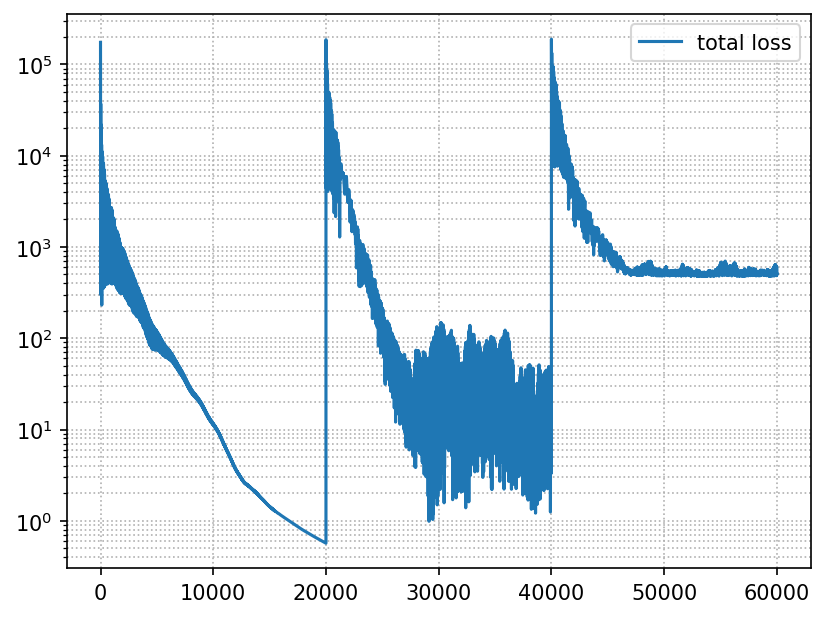

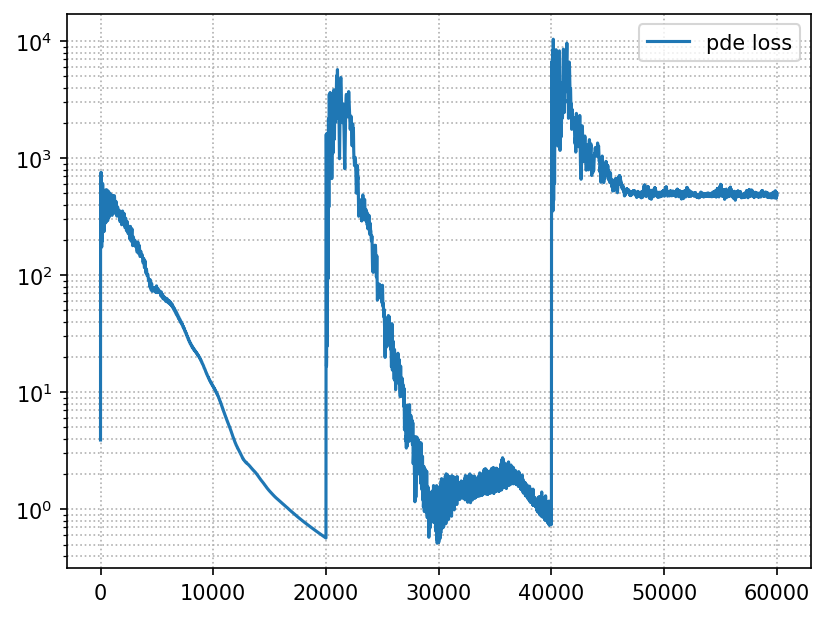

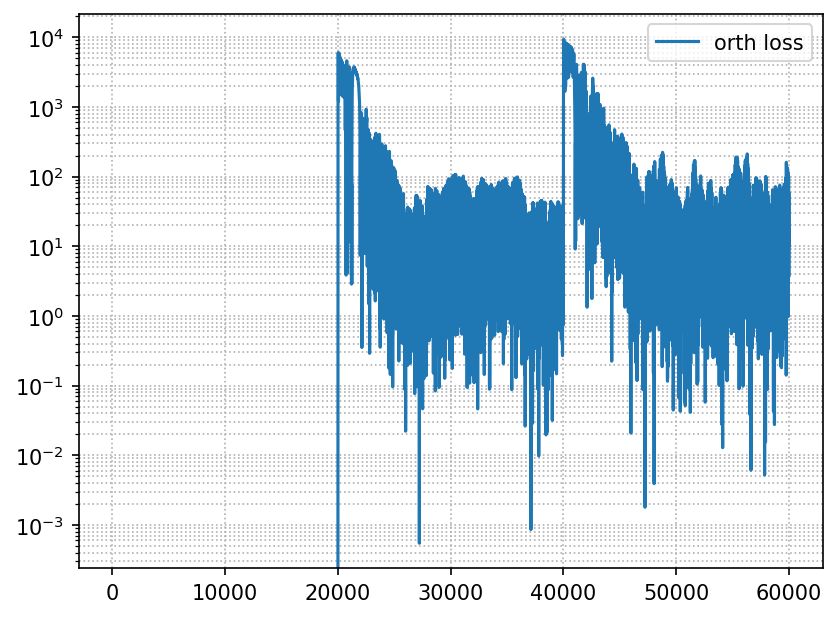

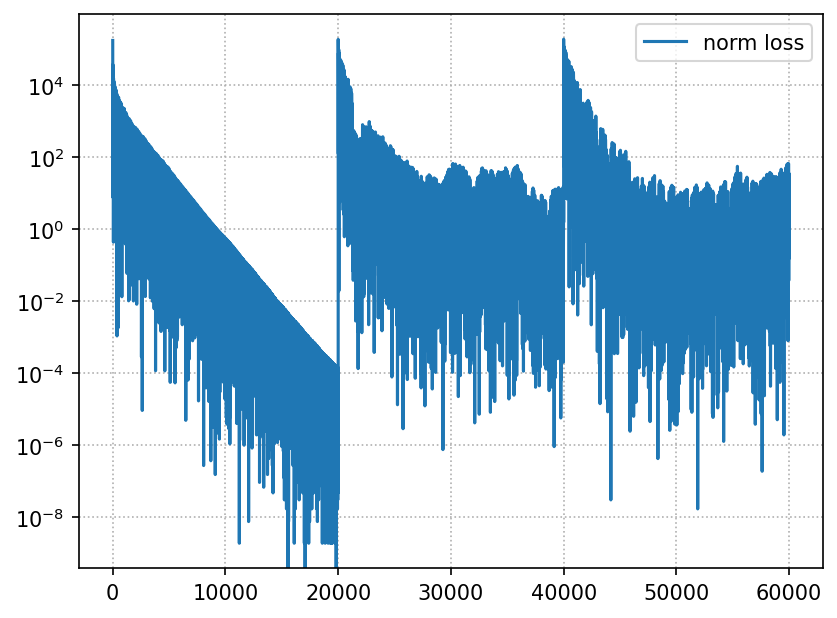

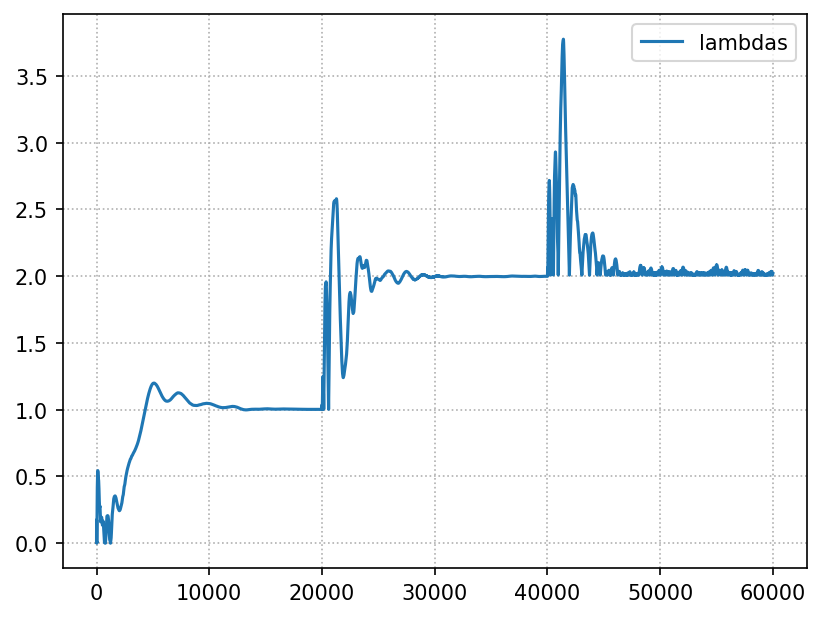

In [ ]:

losses = [(loss_hist, "total loss"), 
          (pde_loss_hist, "pde loss"), 
          (orth_loss_hist, "orth loss"), 
          (norm_loss_hist, "norm loss")]

for loss, titel in losses:
    plt.figure(dpi=150)
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1, len(loss) + 1), loss, label=titel)
    plt.yscale("log")
    plt.legend()
    plt.show

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(lambda_hist) + 1), lambda_hist, label="lambdas")
#plt.yscale("log")
plt.legend()
plt.show

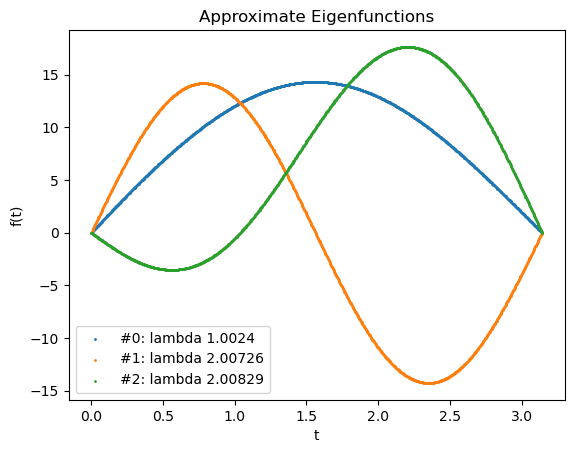

In [ ]:
def plotting(solutions):
    inputs = torch.linspace(0, 1, steps=1000)
    inputs = inputs.reshape(-1,1)
    inputs = np.pi * inputs

    for i, sol in enumerate(solutions):
        nn = sol
        N, lam = nn(inputs)
        N = N.reshape(-1,1)
        f = para_f(inputs, N, np.pi)

        l = np.abs(lam[0].item())
        plt.scatter(inputs.detach(), f.detach(), s=1, label=f'#{i}: lambda {np.round(l,5)}')
        plt.xlabel("t")
        plt.ylabel("f(t)")
        plt.title(f"Approximate Eigenfunctions")
        plt.legend()
    
    plt.show()

plotting(solutions=solutions)